# Python_DeepLearning_Pytorch - part2
#### 딥러닝과 파이토치와 관련된 기본적인 내용을 정리하였습니다. 파이썬 딥러닝 파이토치(이경택, 방성수, 안상주 지음)을 참고하였습니다. 
#### GPU 사용을 위해서 google colab을 활용하여 작성하였습니다.

## 2. AI Background
#### - AI와 관련된 배경지식을 설명하는 파트로 태블릿 메모에 따로 필기 저장

#### 예제 2.1 사람의 손글씨 데이터인 MNIST를 이용해서 MLP 설계하기
#### MLP 모델을 설계하는 순서는 다음과 같다. 
#### 1. 모듈 임포트 - 2. 딥러닝 모델 설계할 때 활용하는 장비 확인 - 3. 데이터 다운 - 4. 데이터 확인1 - 5. 데이터 확인2 - 6. MLP 모델 설계 - 7. Optimizer, Objective 함수 설정 - 8. 학습데이터에 대한 모델 성능 지표 확인 - 9. 검증 데이터에 대한 모델 성능 지표 확인 - 10. train, test set의 loss 및 test set accuacy 확인

In [10]:
#### 1. 모듈 임포트
import numpy as np 
import matplotlib.pyplot as plt
import torch
import torch.nn as nn    #### 인공 신경말 모델 설계를 위한 모듈
import torch.nn.functional as F    #### torch.nn 중 자주 이용되는 함수를 F 로 지정
from torchvision import transforms, datasets    #### 컴퓨터 비전 연구 분야에서 자주 이용하는 모듈

#### 2. 딥러닝 모델 설계할 때 활용하는 장비 확인
if torch.cuda.is_available():
  DEVICE = torch.device('cuda')
else:
  DEVICE = torch.device('cpu')

print('Using PyTorch version: ', torch.__version__, 'Device: ', DEVICE)

#### mini-batch 1개 단위에 대해 데이터 32개로 구성 / 1개의 mini-batch를 이용해 학습하는 횟수를 iteration, 전체 데이터를 이용해 학습 진행 횟수 epoch
#### epoch는 사용자가 정의하는 하이퍼파라미터 / mini-batch의 데이터 개수를 지정해준다면 iteration은 전체 데이터 개수에서 1개의 mini-batch를 구성하는 데이터 개수를 나눠준 몫 만큼 iteration
BATCH_SIZE = 32    
EPOCHS = 10 

#### 3. MNIST 데이터 다운로드
train_dataset = datasets.MNIST(root = "../data/MNIST", train = True, download = True, transform = transforms.ToTensor())
test_dataset = datasets.MNIST(root = "../data/MNIST", train = False, transform = transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size = BATCH_SIZE, shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset, batch_size = BATCH_SIZE, shuffle= False)


Using PyTorch version:  1.8.1+cu101 Device:  cuda
Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ../data/MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ../data/MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ../data/MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ../data/MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [11]:
#### 4. 데이터 확인하기 (1)
for (X_train, y_train) in train_loader:
  print('X_train: ', X_train.size(), 'type: ', X_train.type())
  print('y_train: ', y_train.size(), 'type: ', y_train.type())
  break

X_train:  torch.Size([32, 1, 28, 28]) type:  torch.FloatTensor
y_train:  torch.Size([32]) type:  torch.LongTensor


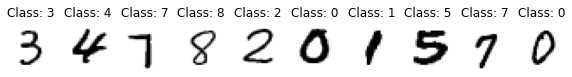

In [13]:
#### 5. 데이터 확인하기 (2)
pltsize = 1
plt.figure(figsize=(10 * pltsize, pltsize))
for i in range(10):
  plt.subplot(1, 10, i +1)
  plt.axis('off')
  plt.imshow(X_train[i, :, :, :].numpy().reshape(28,28), cmap = 'gray_r')
  plt.title('Class: ' + str(y_train[i].item()))

In [14]:
#### 6. MLP 모델 설계
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.fc1 = nn.Linear(28 * 28, 512)
    self.fc2 = nn.Linear(512, 256)
    self.fc3 = nn.Linear(256, 10)
  
  def forward(self, x):
    x = x.view(-1, 28 * 28)    #### 2차원 데이터를 1차원으로 펼친다. Flatten 한다.
    x = self.fc1(x)
    x = F.sigmoid(x)
    x = self.fc2(x)
    x = F.sigmoid(x)
    x = self.fc3(x)
    x = F.log_softmax(x, dim = 1)    #### MLP 모델이 Back Propagation 알고리즘을 이용해 학습할 때 Loss 값에 대한 Gradient 값을 좀 더 원활하게 계산해줄 수 있음
    return x

In [16]:
#### 7. Optimizer, Objective Function 설정
model = Net().to(DEVICE)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum = 0.5)
criterion = nn.CrossEntropyLoss()

print(model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)


In [17]:
#### 8. MLP 학습 데이터에 대한 모델 성능 확인하는 함수 정의
def train(model, train_loader, optimizer, log_interval):
  model.train()
  for batch_idx, (image, label) in enumerate(train_loader):
    image = image.to(DEVICE)
    label = label.to(DEVICE)
    optimizer.zero_grad()
    output = model(image)
    loss = criterion(output, label)
    loss.backward()
    optimizer.step()

    if batch_idx % log_interval == 0:
      print("Train Epoch : {} [{}/{}({:.0f}%)]\tTrain Loss: {:.6f}".format(Epoch, batch_idx * len(image), 
                                                                           len(train_loader.dataset), 100. * batch_idx / len(train_loader), loss.item()))

In [18]:
#### 9. MLP 검증 데이터에 대한 모델 성능을 확인하는 함수 정의
def evaluate(model, test_loader):
  model.eval()
  test_loss = 0
  correct = 0

  with torch.no_grad():
    for image, label in test_loader:
      image = image.to(DEVICE)
      label = label.to(DEVICE)
      output = model(image)
      test_loss += criterion(output, label).item()
      prediction = output.max(1, keepdim = True)[1]
      correct += prediction.eq(label.view_as(prediction)).sum().item()

  test_loss /= len(test_loader.dataset)
  test_accuracy = 100. * correct / len(test_loader.dataset)
  return test_loss, test_accuracy

In [19]:
#### 10. MLP 학습을 실행하며 Train, Test set의 Loss 및 Test set Accuracy 확인
for Epoch in range(1, EPOCHS + 1):
  train(model, train_loader, optimizer, log_interval=200)
  test_loss, test_accuracy = evaluate(model, test_loader)
  print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} %\n".format(Epoch, test_loss, test_accuracy))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch : 1 [0/60000(0%)]	Train Loss: 2.433908
Train Epoch : 1 [6400/60000(11%)]	Train Loss: 2.309557
Train Epoch : 1 [12800/60000(21%)]	Train Loss: 2.328537
Train Epoch : 1 [19200/60000(32%)]	Train Loss: 2.337862
Train Epoch : 1 [25600/60000(43%)]	Train Loss: 2.276689
Train Epoch : 1 [32000/60000(53%)]	Train Loss: 2.277403
Train Epoch : 1 [38400/60000(64%)]	Train Loss: 2.286021
Train Epoch : 1 [44800/60000(75%)]	Train Loss: 2.277734
Train Epoch : 1 [51200/60000(85%)]	Train Loss: 2.291968
Train Epoch : 1 [57600/60000(96%)]	Train Loss: 2.242214

[EPOCH: 1], 	Test Loss: 0.0701, 	Test Accuracy: 32.62 %

Train Epoch : 2 [0/60000(0%)]	Train Loss: 2.236029
Train Epoch : 2 [6400/60000(11%)]	Train Loss: 2.199681
Train Epoch : 2 [12800/60000(21%)]	Train Loss: 2.158814
Train Epoch : 2 [19200/60000(32%)]	Train Loss: 2.151126
Train Epoch : 2 [25600/60000(43%)]	Train Loss: 2.110625
Train Epoch : 2 [32000/60000(53%)]	Train Loss: 1.871842
Train Epoch : 2 [38400/60000(64%)]	Train Loss: 1.752327
Tr